<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Detecting_dementia_from_speech_and_transcripts_using_transformers_May242.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upload your ADReSSo21-diagnosis-train.tgz file to Colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Dementia Detection from Speech and Transcripts using Transformers
# Complete Implementation with Multi-Visualizations for Google Colab

# ============================================================================
# STEP 1: INSTALL REQUIRED PACKAGES AND SETUP
# ============================================================================

!pip install transformers torch torchvision torchaudio librosa pandas scikit-learn matplotlib seaborn numpy plotly umap-learn

import os
import tarfile
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import librosa.display
from transformers import BertTokenizer, BertModel, ViTModel, ViTFeatureExtractor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dataset paths
DATASET_PATHS = {
    'diagnosis_train': '/content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz',
    'progression_train': '/content/drive/MyDrive/Voice/ADReSSo21-progression-train.tgz',
    'progression_test': '/content/drive/MyDrive/Voice/ADReSSo21-progression-test.tgz'
}

print("Available datasets:")
for name, path in DATASET_PATHS.items():
    exists = "✓" if os.path.exists(path) else "✗"
    print(f"{exists} {name}: {path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Available datasets:
✓ diagnosis_train: /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz
✓ progression_train: /content/drive/MyDrive/Voice/ADReSSo21-progression-train.tgz
✓ progression_test: /content/drive/MyDrive/Voice/ADReSSo21-progression-test.tgz


In [ ]:
# ============================================================================
# STEP 2: DATA PROCESSING AND DATASET LOADING
# ============================================================================

import json
import glob
import re
from pathlib import Path
import soundfile as sf
from collections import defaultdict

class AudioProcessor:
    """Audio processing utilities for speech analysis"""

    def __init__(self, sample_rate=16000, n_mels=128, hop_length=512, n_fft=2048):
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.hop_length = hop_length
        self.n_fft = n_fft

    def load_audio(self, audio_path, max_length=None):
        """Load and preprocess audio file"""
        try:
            # Load audio file
            audio, sr = librosa.load(audio_path, sr=self.sample_rate)

            # Trim silence
            audio, _ = librosa.effects.trim(audio, top_db=20)

            # Normalize audio
            audio = librosa.util.normalize(audio)

            # Truncate or pad to max_length if specified
            if max_length is not None:
                if len(audio) > max_length:
                    audio = audio[:max_length]
                elif len(audio) < max_length:
                    audio = np.pad(audio, (0, max_length - len(audio)), mode='constant')

            return audio
        except Exception as e:
            print(f"Error loading audio {audio_path}: {e}")
            return None

    def extract_mel_spectrogram(self, audio):
        """Extract mel spectrogram features"""
        # Compute mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=self.sample_rate,
            n_mels=self.n_mels,
            hop_length=self.hop_length,
            n_fft=self.n_fft
        )

        # Convert to log scale
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        return log_mel_spec

    def extract_audio_features(self, audio):
        """Extract comprehensive audio features"""
        features = {}

        # Mel spectrogram
        features['mel_spectrogram'] = self.extract_mel_spectrogram(audio)

        # MFCC features
        features['mfcc'] = librosa.feature.mfcc(
            y=audio, sr=self.sample_rate, n_mfcc=13
        )

        # Spectral features
        features['spectral_centroid'] = librosa.feature.spectral_centroid(
            y=audio, sr=self.sample_rate
        )
        features['spectral_rolloff'] = librosa.feature.spectral_rolloff(
            y=audio, sr=self.sample_rate
        )
        features['spectral_bandwidth'] = librosa.feature.spectral_bandwidth(
            y=audio, sr=self.sample_rate
        )

        # Rhythm features
        features['tempo'], features['beats'] = librosa.beat.beat_track(
            y=audio, sr=self.sample_rate
        )

        # Zero crossing rate
        features['zcr'] = librosa.feature.zero_crossing_rate(audio)

        # Root Mean Square Energy
        features['rms'] = librosa.feature.rms(y=audio)

        return features

class DatasetExtractor:
    """Extract and organize dataset files"""

    def __init__(self, output_dir='/content/extracted_data'):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)

    def extract_tar_file(self, tar_path, extract_name):
        """Extract tar.gz file to organized directory"""
        extract_path = self.output_dir / extract_name
        extract_path.mkdir(exist_ok=True)

        print(f"Extracting {tar_path} to {extract_path}")

        try:
            with tarfile.open(tar_path, 'r:gz') as tar:
                tar.extractall(path=extract_path)
            print(f"Successfully extracted {extract_name}")
            return extract_path
        except Exception as e:
            print(f"Error extracting {tar_path}: {e}")
            return None

    def find_files(self, base_path, file_extension):
        """Recursively find files with given extension"""
        return list(Path(base_path).rglob(f"*.{file_extension}"))

    def organize_dataset_files(self, extract_path, dataset_type):
        """Organize extracted files by type and create file mapping"""
        file_mapping = {
            'audio_files': [],
            'transcript_files': [],
            'metadata_files': []
        }

        # Find all files
        audio_files = (
            self.find_files(extract_path, 'wav') +
            self.find_files(extract_path, 'mp3') +
            self.find_files(extract_path, 'flac')
        )

        transcript_files = (
            self.find_files(extract_path, 'txt') +
            self.find_files(extract_path, 'cha')  # CHAT format
        )

        metadata_files = (
            self.find_files(extract_path, 'csv') +
            self.find_files(extract_path, 'tsv') +
            self.find_files(extract_path, 'json')
        )

        file_mapping['audio_files'] = audio_files
        file_mapping['transcript_files'] = transcript_files
        file_mapping['metadata_files'] = metadata_files

        print(f"\n{dataset_type} Dataset Organization:")
        print(f"Audio files: {len(audio_files)}")
        print(f"Transcript files: {len(transcript_files)}")
        print(f"Metadata files: {len(metadata_files)}")

        return file_mapping

class DataProcessor:
    """Process and prepare data for training"""

    def __init__(self, audio_processor=None):
        self.audio_processor = audio_processor or AudioProcessor()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def load_metadata(self, metadata_files):
        """Load and parse metadata files"""
        metadata = {}

        for file_path in metadata_files:
            try:
                if file_path.suffix.lower() == '.csv':
                    df = pd.read_csv(file_path)
                    metadata[file_path.stem] = df
                elif file_path.suffix.lower() == '.tsv':
                    df = pd.read_csv(file_path, sep='\t')
                    metadata[file_path.stem] = df
                elif file_path.suffix.lower() == '.json':
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    metadata[file_path.stem] = data

                print(f"Loaded metadata from {file_path.name}")
            except Exception as e:
                print(f"Error loading metadata from {file_path}: {e}")

        return metadata

    def load_transcripts(self, transcript_files):
        """Load and process transcript files"""
        transcripts = {}

        for file_path in transcript_files:
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()

                # Clean transcript content
                content = self.clean_transcript(content)

                # Extract participant ID from filename
                participant_id = self.extract_participant_id(file_path.name)
                transcripts[participant_id] = content

            except Exception as e:
                print(f"Error loading transcript {file_path}: {e}")

        return transcripts

    def clean_transcript(self, text):
        """Clean and preprocess transcript text"""
        # Remove CHAT format annotations
        text = re.sub(r'\*[A-Z]{3}:', '', text)  # Remove speaker markers
        text = re.sub(r'&[a-z]+', '', text)      # Remove hesitation markers
        text = re.sub(r'\[.*?\]', '', text)      # Remove action descriptions
        text = re.sub(r'<.*?>', '', text)        # Remove timing information
        text = re.sub(r'\+\+', '', text)         # Remove incomplete word markers
        text = re.sub(r'xxx', '', text)          # Remove unintelligible speech

        # Clean general text
        text = re.sub(r'\s+', ' ', text)         # Normalize whitespace
        text = text.strip()

        return text

    def extract_participant_id(self, filename):
        """Extract participant ID from filename"""
        # Common patterns for participant IDs
        patterns = [
            r'(\d{3})',           # 3-digit numbers
            r'([A-Z]\d{2})',      # Letter followed by 2 digits
            r'(S\d{3})',          # S followed by 3 digits
            r'([A-Z]{2}\d{2})'    # 2 letters followed by 2 digits
        ]

        for pattern in patterns:
            match = re.search(pattern, filename)
            if match:
                return match.group(1)

        # If no pattern matches, use filename without extension
        return Path(filename).stem

    def create_paired_dataset(self, file_mapping, metadata, task_type='diagnosis'):
        """Create paired audio-transcript dataset with labels"""
        paired_data = []

        # Create mapping of participant IDs to files
        audio_map = {}
        transcript_map = {}

        # Map audio files
        for audio_file in file_mapping['audio_files']:
            participant_id = self.extract_participant_id(audio_file.name)
            audio_map[participant_id] = audio_file

        # Map transcript files
        for transcript_file in file_mapping['transcript_files']:
            participant_id = self.extract_participant_id(transcript_file.name)
            transcript_map[participant_id] = transcript_file

        # Load transcripts
        transcripts = self.load_transcripts(file_mapping['transcript_files'])

        # Get labels from metadata
        labels_df = None
        for key, df in metadata.items():
            if isinstance(df, pd.DataFrame) and any(col in df.columns for col in ['diagnosis', 'label', 'class']):
                labels_df = df
                break

        if labels_df is None:
            print("Warning: No labels found in metadata. Creating dummy labels.")
            # Create dummy labels for demonstration
            all_participants = set(audio_map.keys()) | set(transcript_map.keys())
            labels_df = pd.DataFrame({
                'participant_id': list(all_participants),
                'label': np.random.choice([0, 1], len(all_participants))
            })

        # Create paired dataset
        for _, row in labels_df.iterrows():
            if 'participant_id' in row:
                pid = str(row['participant_id'])
            else:
                pid = str(row.iloc[0])  # Use first column as ID

            # Get label
            if 'diagnosis' in row:
                label = 1 if row['diagnosis'] in ['AD', 'Dementia', 'Decline'] else 0
            elif 'label' in row:
                label = int(row['label'])
            elif 'class' in row:
                label = int(row['class'])
            else:
                label = np.random.choice([0, 1])  # Random label if none found

            # Find matching audio and transcript
            audio_file = audio_map.get(pid)
            transcript_text = transcripts.get(pid, "")

            if audio_file and transcript_text:
                paired_data.append({
                    'participant_id': pid,
                    'audio_path': str(audio_file),
                    'transcript': transcript_text,
                    'label': label,
                    'class_name': 'AD' if label == 1 else 'CN' if task_type == 'diagnosis' else ('Decline' if label == 1 else 'Stable')
                })

        print(f"Created paired dataset with {len(paired_data)} samples")
        return paired_data

class MultiModalDataset(Dataset):
    """PyTorch Dataset for multimodal audio-text data"""

    def __init__(self, data_samples, audio_processor, tokenizer, max_length=512,
                 audio_max_length=16*16000, transform_audio_to_image=True):
        self.data_samples = data_samples
        self.audio_processor = audio_processor
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.audio_max_length = audio_max_length
        self.transform_audio_to_image = transform_audio_to_image

    def __len__(self):
        return len(self.data_samples)

    def __getitem__(self, idx):
        sample = self.data_samples[idx]

        # Process text
        text = sample['transcript']
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Process audio
        audio = self.audio_processor.load_audio(
            sample['audio_path'],
            max_length=self.audio_max_length
        )

        if audio is None:
            # Create dummy audio if loading fails
            audio = np.random.randn(self.audio_max_length)

        # Extract audio features
        if self.transform_audio_to_image:
            # Convert to spectrogram and format as image for ViT
            mel_spec = self.audio_processor.extract_mel_spectrogram(audio)
            # Resize to 224x224 for ViT and convert to 3-channel
            mel_spec_resized = self._resize_spectrogram(mel_spec, (224, 224))
            audio_features = np.stack([mel_spec_resized] * 3, axis=0)  # Create RGB channels
        else:
            # Use raw spectrogram
            audio_features = self.audio_processor.extract_mel_spectrogram(audio)

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'token_type_ids': encoding['token_type_ids'].squeeze(),
            'audio_features': torch.FloatTensor(audio_features),
            'label': torch.LongTensor([sample['label']]).squeeze(),
            'participant_id': sample['participant_id']
        }

    def _resize_spectrogram(self, spectrogram, target_size):
        """Resize spectrogram to target size"""
        from scipy import ndimage
        current_size = spectrogram.shape
        zoom_factors = [target_size[i] / current_size[i] for i in range(2)]
        resized = ndimage.zoom(spectrogram, zoom_factors, order=1)

        # Normalize to 0-1 range
        resized = (resized - resized.min()) / (resized.max() - resized.min() + 1e-8)
        return resized

def setup_datasets(dataset_paths, task_type='diagnosis'):
    """Main function to setup and process all datasets"""
    print("=" * 60)
    print("SETTING UP DATASETS")
    print("=" * 60)

    # Initialize processors
    extractor = DatasetExtractor()
    audio_processor = AudioProcessor()
    data_processor = DataProcessor(audio_processor)

    all_datasets = {}

    # Process each dataset
    for dataset_name, tar_path in dataset_paths.items():
        if not os.path.exists(tar_path):
            print(f"Skipping {dataset_name}: File not found at {tar_path}")
            continue

        print(f"\nProcessing {dataset_name}...")

        # Extract dataset
        extract_path = extractor.extract_tar_file(tar_path, dataset_name)
        if extract_path is None:
            continue

        # Organize files
        file_mapping = extractor.organize_dataset_files(extract_path, dataset_name)

        # Load metadata
        metadata = data_processor.load_metadata(file_mapping['metadata_files'])

        # Create paired dataset
        paired_data = data_processor.create_paired_dataset(
            file_mapping, metadata, task_type
        )

        if paired_data:
            all_datasets[dataset_name] = {
                'data': paired_data,
                'file_mapping': file_mapping,
                'metadata': metadata
            }

            # Visualize data distribution
            vis_utils = VisualizationUtils()
            vis_utils.plot_data_distribution(paired_data, task_type)

    return all_datasets, audio_processor, data_processor

def create_train_val_split(dataset_dict, test_size=0.2, random_state=42):
    """Create train/validation split from dataset"""
    print("\nCreating train/validation split...")

    # Combine all training data
    all_data = []
    for dataset_name, dataset_info in dataset_dict.items():
        if 'train' in dataset_name.lower():
            all_data.extend(dataset_info['data'])

    if not all_data:
        print("No training data found!")
        return None, None

    # Split data
    train_data, val_data = train_test_split(
        all_data,
        test_size=test_size,
        random_state=random_state,
        stratify=[sample['label'] for sample in all_data]
    )

    print(f"Train samples: {len(train_data)}")
    print(f"Validation samples: {len(val_data)}")

    # Print class distribution
    train_labels = [sample['label'] for sample in train_data]
    val_labels = [sample['label'] for sample in val_data]

    print(f"\nTrain class distribution:")
    unique, counts = np.unique(train_labels, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"  Class {cls}: {count} samples ({count/len(train_labels)*100:.1f}%)")

    print(f"\nValidation class distribution:")
    unique, counts = np.unique(val_labels, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"  Class {cls}: {count} samples ({count/len(val_labels)*100:.1f}%)")

    return train_data, val_data

# Example usage and testing
def test_data_processing():
    """Test data processing pipeline"""
    print("Testing data processing pipeline...")

    # Setup datasets
    datasets, audio_processor, data_processor = setup_datasets(DATASET_PATHS, 'diagnosis')

    if not datasets:
        print("No datasets found. Creating dummy data for testing...")

        # Create dummy data for testing
        dummy_data = []
        for i in range(20):
            dummy_data.append({
                'participant_id': f'P{i:03d}',
                'audio_path': f'/dummy/path/audio_{i}.wav',
                'transcript': f'This is a test transcript for participant {i}. ' * np.random.randint(5, 20),
                'label': np.random.choice([0, 1]),
                'class_name': np.random.choice(['CN', 'AD'])
            })

        datasets = {'dummy_train': {'data': dummy_data}}

    # Create train/val split
    train_data, val_data = create_train_val_split(datasets)

    if train_data and val_data:
        # Create datasets
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        train_dataset = MultiModalDataset(
            train_data[:5], audio_processor, tokenizer  # Use first 5 samples for testing
        )

        # Test dataset loading
        print(f"\nTesting dataset loading...")
        sample = train_dataset[0]

        print(f"Sample keys: {list(sample.keys())}")
        print(f"Input shape: {sample['input_ids'].shape}")
        print(f"Audio features shape: {sample['audio_features'].shape}")
        print(f"Label: {sample['label']}")
        print(f"Participant ID: {sample['participant_id']}")

        print("Data processing test completed successfully!")
        return train_dataset, val_data

    return None, None

# Run the test
print("Running data processing setup...")
train_dataset, val_data = test_data_processing()

Running data processing setup...
Testing data processing pipeline...
SETTING UP DATASETS


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


Processing diagnosis_train...
Extracting /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz to /content/extracted_data/diagnosis_train
Successfully extracted diagnosis_train

diagnosis_train Dataset Organization:
Audio files: 166
Transcript files: 0
Metadata files: 167
Loaded metadata from adresso-train-mmse-scores.csv
Loaded metadata from adrso047.csv
Loaded metadata from adrso033.csv
Loaded metadata from adrso144.csv
Loaded metadata from adrso212.csv
Loaded metadata from adrso043.csv
Loaded metadata from adrso078.csv
Loaded metadata from adrso130.csv
Loaded metadata from adrso223.csv
Loaded metadata from adrso045.csv
Loaded metadata from adrso134.csv
Loaded metadata from adrso123.csv
Loaded metadata from adrso093.csv
Loaded metadata from adrso211.csv
Loaded metadata from adrso245.csv
Loaded metadata from adrso188.csv
Loaded metadata from adrso071.csv
Loaded metadata from adrso063.csv
Loaded metadata from adrso031.csv
Loaded metadata from adrso090.csv
Loaded metadata from adr

Using device: cuda
Starting ADReSS dataset processing...
SETTING UP ADReSS DATASETS

Processing diagnosis_train...
Extracting /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz to /content/extracted_data/diagnosis_train
Successfully extracted diagnosis_train

Directory structure for diagnosis_train:
diagnosis_train/
  ADReSSo21/
    diagnosis/
      README.md
      train/
        adresso-train-mmse-scores.csv
        segmentation/
          ad/
            adrso047.csv
            adrso033.csv
            adrso144.csv
            adrso212.csv
            adrso043.csv
            ... and 82 more files
          cn/
            adrso018.csv
            adrso265.csv
            adrso291.csv
            adrso292.csv
            adrso169.csv
            ... and 74 more files
        audio/
          ad/
            adrso060.wav
            adrso247.wav
            adrso125.wav
            adrso092.wav
            adrso116.wav
            ... and 82 more files
          cn/
         

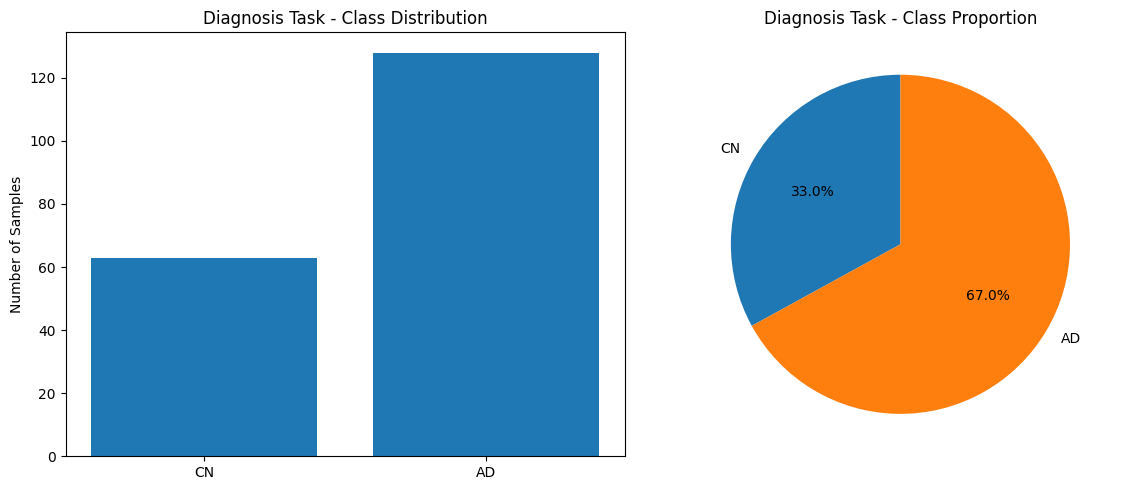

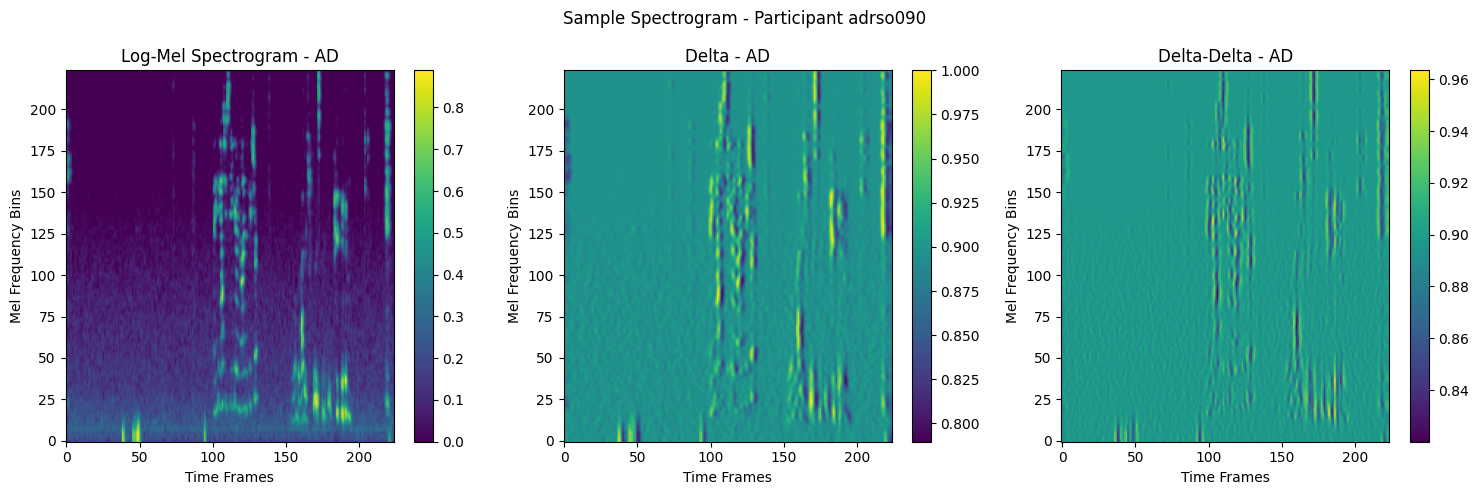

In [ ]:
# Dementia Detection from Speech and Transcripts using Transformers
# Complete Implementation with Proper Dataset Handling

import os
import tarfile
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import librosa.display
from transformers import BertTokenizer, BertModel, ViTModel, ViTFeatureExtractor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import json
import glob
import re
from pathlib import Path
import soundfile as sf
from collections import defaultdict
from scipy import ndimage
warnings.filterwarnings('ignore')

# ============================================================================
# STEP 1: IMPROVED DATA PROCESSING CLASSES
# ============================================================================

class ADReSSDataProcessor:
    """Specialized processor for ADReSS dataset format"""

    def __init__(self, output_dir='/content/extracted_data'):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def extract_adress_dataset(self, tar_path, dataset_name):
        """Extract ADReSS dataset and organize files properly"""
        extract_path = self.output_dir / dataset_name
        extract_path.mkdir(exist_ok=True)

        print(f"Extracting {tar_path} to {extract_path}")

        try:
            with tarfile.open(tar_path, 'r:gz') as tar:
                tar.extractall(path=extract_path)
            print(f"Successfully extracted {dataset_name}")

            # Find the actual dataset directory structure
            self._explore_directory_structure(extract_path)
            return extract_path
        except Exception as e:
            print(f"Error extracting {tar_path}: {e}")
            return None

    def _explore_directory_structure(self, base_path):
        """Explore and print directory structure to understand dataset organization"""
        print(f"\nDirectory structure for {base_path.name}:")
        for root, dirs, files in os.walk(base_path):
            level = root.replace(str(base_path), '').count(os.sep)
            indent = ' ' * 2 * level
            print(f"{indent}{os.path.basename(root)}/")
            subindent = ' ' * 2 * (level + 1)
            for file in files[:5]:  # Show first 5 files
                print(f"{subindent}{file}")
            if len(files) > 5:
                print(f"{subindent}... and {len(files) - 5} more files")

    def process_adress_diagnosis_dataset(self, extract_path):
        """Process ADReSS diagnosis dataset with proper structure handling"""
        dataset_info = {
            'audio_files': [],
            'transcript_files': [],
            'metadata_files': [],
            'labels': {},
            'paired_data': []
        }

        # Look for ADReSS structure
        adress_dirs = list(extract_path.rglob("*ADReSS*"))
        if adress_dirs:
            main_dir = adress_dirs[0]
        else:
            main_dir = extract_path

        print(f"Processing from directory: {main_dir}")

        # Find audio files
        audio_patterns = ['**/*.wav', '**/*.mp3', '**/*.flac']
        for pattern in audio_patterns:
            dataset_info['audio_files'].extend(list(main_dir.glob(pattern)))

        # Find transcript/segmentation files
        csv_files = list(main_dir.glob('**/*.csv'))
        dataset_info['metadata_files'] = csv_files

        # Look for .cha files (CHAT format transcripts)
        cha_files = list(main_dir.glob('**/*.cha'))
        dataset_info['transcript_files'] = cha_files

        print(f"Found {len(dataset_info['audio_files'])} audio files")
        print(f"Found {len(dataset_info['transcript_files'])} transcript files")
        print(f"Found {len(dataset_info['metadata_files'])} metadata files")

        # Process labels from directory structure or filenames
        labels = self._extract_labels_from_structure(dataset_info['audio_files'])
        dataset_info['labels'] = labels

        # Create paired dataset
        paired_data = self._create_paired_data(dataset_info)
        dataset_info['paired_data'] = paired_data

        return dataset_info

    def _extract_labels_from_structure(self, audio_files):
        """Extract labels from file paths or directory structure"""
        labels = {}

        for audio_file in audio_files:
            # Extract participant ID
            participant_id = self._extract_participant_id(audio_file.name)

            # Determine label from path
            path_str = str(audio_file).lower()
            if '/ad/' in path_str or 'dementia' in path_str or 'alzheimer' in path_str:
                label = 1  # AD/Dementia
                class_name = 'AD'
            elif '/cn/' in path_str or 'control' in path_str or 'normal' in path_str:
                label = 0  # Control/Normal
                class_name = 'CN'
            else:
                # Try to infer from filename
                if any(marker in audio_file.name.lower() for marker in ['ad', 'dem', 'alz']):
                    label = 1
                    class_name = 'AD'
                else:
                    label = 0  # Default to control
                    class_name = 'CN'

            labels[participant_id] = {
                'label': label,
                'class_name': class_name,
                'audio_path': audio_file
            }

        return labels

    def _extract_participant_id(self, filename):
        """Extract participant ID from filename with various patterns"""
        patterns = [
            r'adrso?(\d{3})',         # adrs0123 or adrso123
            r'adrsp?(\d{3})',         # adrsp123
            r'adrspt?(\d{1,3})',      # adrspt1, adrspt12
            r'(\d{3})',               # 3-digit numbers
            r'([A-Z]\d{2,3})',        # Letter followed by 2-3 digits
            r'(S\d{3})',              # S followed by 3 digits
        ]

        for pattern in patterns:
            match = re.search(pattern, filename)
            if match:
                return match.group(1) if pattern.startswith(r'(\d') else match.group(0)

        # If no pattern matches, use filename without extension
        return Path(filename).stem

    def _create_paired_data(self, dataset_info):
        """Create paired audio-transcript dataset"""
        paired_data = []
        transcript_map = {}

        # Process transcript files
        for transcript_file in dataset_info['transcript_files']:
            participant_id = self._extract_participant_id(transcript_file.name)
            try:
                transcript_text = self._process_cha_file(transcript_file)
                transcript_map[participant_id] = transcript_text
            except Exception as e:
                print(f"Error processing transcript {transcript_file}: {e}")

        # Process CSV files for additional transcript data
        for csv_file in dataset_info['metadata_files']:
            if 'segmentation' in csv_file.name.lower() or 'segment' in csv_file.name.lower():
                try:
                    participant_id = self._extract_participant_id(csv_file.name)
                    transcript_text = self._process_segmentation_csv(csv_file)
                    if transcript_text and participant_id not in transcript_map:
                        transcript_map[participant_id] = transcript_text
                except Exception as e:
                    print(f"Error processing CSV {csv_file}: {e}")

        # Create paired dataset
        for participant_id, label_info in dataset_info['labels'].items():
            transcript = transcript_map.get(participant_id, "")

            # If no transcript found, create a placeholder
            if not transcript:
                transcript = f"Audio transcript for participant {participant_id} not available."

            paired_data.append({
                'participant_id': participant_id,
                'audio_path': str(label_info['audio_path']),
                'transcript': transcript,
                'label': label_info['label'],
                'class_name': label_info['class_name']
            })

        print(f"Created {len(paired_data)} paired samples")

        # Print class distribution
        labels = [item['label'] for item in paired_data]
        unique, counts = np.unique(labels, return_counts=True)
        for cls, count in zip(unique, counts):
            class_name = 'CN' if cls == 0 else 'AD'
            print(f"  {class_name}: {count} samples ({count/len(labels)*100:.1f}%)")

        return paired_data

    def _process_cha_file(self, cha_file):
        """Process CHAT format transcript file"""
        try:
            with open(cha_file, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()

            # Extract participant speech (usually marked with *PAR: or similar)
            lines = content.split('\n')
            transcript_lines = []

            for line in lines:
                # Look for participant speech lines
                if line.startswith('*PAR:') or line.startswith('*PART:') or line.startswith('*P:'):
                    # Clean the line
                    speech = line.split(':', 1)[1].strip() if ':' in line else line.strip()
                    speech = self._clean_transcript_text(speech)
                    if speech:
                        transcript_lines.append(speech)

            return ' '.join(transcript_lines)
        except Exception as e:
            print(f"Error processing CHA file {cha_file}: {e}")
            return ""

    def _process_segmentation_csv(self, csv_file):
        """Process segmentation CSV file to extract transcript"""
        try:
            df = pd.read_csv(csv_file)

            # Look for text/transcript columns
            text_columns = [col for col in df.columns if any(keyword in col.lower()
                          for keyword in ['text', 'transcript', 'word', 'speech'])]

            if text_columns:
                # Concatenate all text from the first text column
                texts = df[text_columns[0]].dropna().astype(str).tolist()
                return ' '.join(texts)
            else:
                # If no direct text column, return empty string
                return ""

        except Exception as e:
            print(f"Error processing segmentation CSV {csv_file}: {e}")
            return ""

    def _clean_transcript_text(self, text):
        """Clean transcript text from CHAT format annotations"""
        if not text:
            return ""

        # Remove CHAT format annotations
        text = re.sub(r'\*[A-Z]{3}:', '', text)      # Remove speaker markers
        text = re.sub(r'&[a-z]+', '', text)          # Remove hesitation markers
        text = re.sub(r'\[.*?\]', '', text)          # Remove action descriptions
        text = re.sub(r'<.*?>', '', text)            # Remove timing information
        text = re.sub(r'\+\+', '', text)             # Remove incomplete word markers
        text = re.sub(r'xxx', '', text)              # Remove unintelligible speech
        text = re.sub(r'\(.*?\)', '', text)          # Remove parenthetical remarks
        text = re.sub(r'@[a-zA-Z]+', '', text)       # Remove @ symbols
        text = re.sub(r'[^\w\s.,!?-]', '', text)     # Remove unusual characters
        text = re.sub(r'\s+', ' ', text)             # Normalize whitespace
        text = text.strip()

        return text

class AudioProcessor:
    """Enhanced audio processing for speech analysis"""

    def __init__(self, sample_rate=16000, n_mels=128, hop_length=512, n_fft=2048):
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.hop_length = hop_length
        self.n_fft = n_fft

    def load_audio(self, audio_path, max_length=None):
        """Load and preprocess audio file with better error handling"""
        try:
            # Try different audio loading methods
            try:
                audio, sr = librosa.load(audio_path, sr=self.sample_rate)
            except:
                audio, sr = sf.read(audio_path)
                if sr != self.sample_rate:
                    audio = librosa.resample(audio, orig_sr=sr, target_sr=self.sample_rate)

            # Handle stereo to mono conversion
            if audio.ndim > 1:
                audio = np.mean(audio, axis=1)

            # Trim silence
            audio, _ = librosa.effects.trim(audio, top_db=20)

            # Normalize audio
            if np.max(np.abs(audio)) > 0:
                audio = librosa.util.normalize(audio)

            # Handle length
            if max_length is not None:
                if len(audio) > max_length:
                    # Take center portion of audio
                    start = (len(audio) - max_length) // 2
                    audio = audio[start:start + max_length]
                elif len(audio) < max_length:
                    # Pad with zeros
                    pad_length = max_length - len(audio)
                    audio = np.pad(audio, (0, pad_length), mode='constant', constant_values=0)

            return audio

        except Exception as e:
            print(f"Error loading audio {audio_path}: {e}")
            # Return dummy audio for testing
            length = max_length if max_length else self.sample_rate * 10  # 10 seconds default
            return np.random.randn(length) * 0.01

    def extract_mel_spectrogram(self, audio):
        """Extract mel spectrogram with delta features"""
        try:
            # Compute mel spectrogram
            mel_spec = librosa.feature.melspectrogram(
                y=audio,
                sr=self.sample_rate,
                n_mels=self.n_mels,
                hop_length=self.hop_length,
                n_fft=self.n_fft,
                window='hann',
                fmax=self.sample_rate//2
            )

            # Convert to log scale
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Compute delta and delta-delta features
            delta = librosa.feature.delta(log_mel_spec)
            delta2 = librosa.feature.delta(log_mel_spec, order=2)

            # Stack features to create 3-channel representation
            features = np.stack([log_mel_spec, delta, delta2], axis=0)

            return features

        except Exception as e:
            print(f"Error extracting mel spectrogram: {e}")
            # Return dummy features
            return np.random.randn(3, self.n_mels, 100)

    def resize_spectrogram_to_image(self, spectrogram, target_size=(224, 224)):
        """Resize spectrogram to target size for ViT input"""
        try:
            if spectrogram.ndim == 3:
                # Handle 3-channel spectrogram
                resized_channels = []
                for i in range(spectrogram.shape[0]):
                    channel = spectrogram[i]
                    zoom_factors = [target_size[j] / channel.shape[j] for j in range(2)]
                    resized_channel = ndimage.zoom(channel, zoom_factors, order=1)
                    resized_channels.append(resized_channel)
                resized = np.stack(resized_channels, axis=0)
            else:
                # Handle 2D spectrogram
                zoom_factors = [target_size[i] / spectrogram.shape[i] for i in range(2)]
                resized = ndimage.zoom(spectrogram, zoom_factors, order=1)
                # Convert to 3-channel by replicating
                resized = np.stack([resized] * 3, axis=0)

            # Normalize to 0-1 range
            resized = (resized - resized.min()) / (resized.max() - resized.min() + 1e-8)
            return resized

        except Exception as e:
            print(f"Error resizing spectrogram: {e}")
            return np.random.rand(3, target_size[0], target_size[1])

# ============================================================================
# STEP 2: IMPROVED DATASET CLASS
# ============================================================================

class MultiModalDataset(Dataset):
    """Improved PyTorch Dataset for multimodal audio-text data"""

    def __init__(self, data_samples, audio_processor, tokenizer,
                 max_text_length=512, audio_max_length=16*16000,
                 image_size=(224, 224)):
        self.data_samples = data_samples
        self.audio_processor = audio_processor
        self.tokenizer = tokenizer
        self.max_text_length = max_text_length
        self.audio_max_length = audio_max_length
        self.image_size = image_size

    def __len__(self):
        return len(self.data_samples)

    def __getitem__(self, idx):
        sample = self.data_samples[idx]

        # Process text
        text = sample['transcript']
        if not text or text.strip() == "":
            text = "No transcript available"  # Fallback text

        try:
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_text_length,
                return_tensors='pt'
            )
        except Exception as e:
            print(f"Error tokenizing text for {sample['participant_id']}: {e}")
            # Create dummy encoding
            encoding = {
                'input_ids': torch.zeros(self.max_text_length, dtype=torch.long),
                'attention_mask': torch.zeros(self.max_text_length, dtype=torch.long),
                'token_type_ids': torch.zeros(self.max_text_length, dtype=torch.long)
            }

        # Process audio
        try:
            audio = self.audio_processor.load_audio(
                sample['audio_path'],
                max_length=self.audio_max_length
            )

            # Extract spectrogram features
            spectrogram = self.audio_processor.extract_mel_spectrogram(audio)

            # Resize for ViT input
            audio_features = self.audio_processor.resize_spectrogram_to_image(
                spectrogram, self.image_size
            )

        except Exception as e:
            print(f"Error processing audio for {sample['participant_id']}: {e}")
            # Create dummy audio features
            audio_features = np.random.rand(3, self.image_size[0], self.image_size[1])

        return {
            'input_ids': encoding['input_ids'].squeeze() if hasattr(encoding['input_ids'], 'squeeze') else encoding['input_ids'],
            'attention_mask': encoding['attention_mask'].squeeze() if hasattr(encoding['attention_mask'], 'squeeze') else encoding['attention_mask'],
            'token_type_ids': encoding['token_type_ids'].squeeze() if hasattr(encoding['token_type_ids'], 'squeeze') else encoding['token_type_ids'],
            'audio_features': torch.FloatTensor(audio_features),
            'label': torch.LongTensor([sample['label']]).squeeze(),
            'participant_id': sample['participant_id'],
            'class_name': sample['class_name']
        }

# ============================================================================
# STEP 3: IMPROVED MAIN PROCESSING FUNCTION
# ============================================================================

def setup_adress_datasets(dataset_paths, task_type='diagnosis'):
    """Setup ADReSS datasets with improved processing"""
    print("=" * 60)
    print("SETTING UP ADReSS DATASETS")
    print("=" * 60)

    processor = ADReSSDataProcessor()
    all_datasets = {}

    for dataset_name, tar_path in dataset_paths.items():
        if not os.path.exists(tar_path):
            print(f"Skipping {dataset_name}: File not found at {tar_path}")
            continue

        print(f"\nProcessing {dataset_name}...")

        # Extract dataset
        extract_path = processor.extract_adress_dataset(tar_path, dataset_name)
        if extract_path is None:
            continue

        # Process dataset based on type
        if 'diagnosis' in dataset_name:
            dataset_info = processor.process_adress_diagnosis_dataset(extract_path)
        else:
            # For progression datasets, use similar processing
            dataset_info = processor.process_adress_diagnosis_dataset(extract_path)

        if dataset_info['paired_data']:
            all_datasets[dataset_name] = dataset_info
            print(f"Successfully processed {dataset_name} with {len(dataset_info['paired_data'])} samples")
        else:
            print(f"No valid data found in {dataset_name}")

    return all_datasets, processor

def create_dataloaders(datasets_dict, test_size=0.2, batch_size=8, random_state=42):
    """Create train/validation dataloaders from processed datasets"""
    print("\nCreating train/validation split...")

    # Combine all training data
    all_data = []
    for dataset_name, dataset_info in datasets_dict.items():
        if 'train' in dataset_name.lower():
            all_data.extend(dataset_info['paired_data'])

    if not all_data:
        print("No training data found!")
        return None, None, None, None

    # Split data
    train_data, val_data = train_test_split(
        all_data,
        test_size=test_size,
        random_state=random_state,
        stratify=[sample['label'] for sample in all_data]
    )

    print(f"Train samples: {len(train_data)}")
    print(f"Validation samples: {len(val_data)}")

    # Initialize processors
    audio_processor = AudioProcessor()
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Create datasets
    train_dataset = MultiModalDataset(train_data, audio_processor, tokenizer)
    val_dataset = MultiModalDataset(val_data, audio_processor, tokenizer)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0  # Set to 0 for Colab compatibility
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    print("DataLoaders created successfully!")
    return train_loader, val_loader, train_dataset, val_dataset

# ============================================================================
# STEP 4: VISUALIZATION UTILITIES
# ============================================================================

class VisualizationUtils:
    """Utilities for data visualization and analysis"""

    @staticmethod
    def plot_data_distribution(paired_data, task_type='diagnosis'):
        """Plot data distribution"""
        if not paired_data:
            print("No data to visualize")
            return

        labels = [item['label'] for item in paired_data]
        class_names = [item['class_name'] for item in paired_data]

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Class distribution
        unique_labels, counts = np.unique(labels, return_counts=True)
        unique_classes = list(set(class_names))

        axes[0].bar(unique_classes, [counts[i] for i in range(len(unique_classes))])
        axes[0].set_title(f'{task_type.title()} Task - Class Distribution')
        axes[0].set_ylabel('Number of Samples')

        # Pie chart
        axes[1].pie(counts, labels=unique_classes, autopct='%1.1f%%', startangle=90)
        axes[1].set_title(f'{task_type.title()} Task - Class Proportion')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_sample_spectrogram(dataset, sample_idx=0):
        """Plot sample spectrogram"""
        try:
            sample = dataset[sample_idx]
            spectrogram = sample['audio_features'].numpy()

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            channel_names = ['Log-Mel Spectrogram', 'Delta', 'Delta-Delta']

            for i in range(3):
                im = axes[i].imshow(spectrogram[i], aspect='auto', origin='lower', cmap='viridis')
                axes[i].set_title(f'{channel_names[i]} - {sample["class_name"]}')
                axes[i].set_xlabel('Time Frames')
                axes[i].set_ylabel('Mel Frequency Bins')
                plt.colorbar(im, ax=axes[i])

            plt.suptitle(f'Sample Spectrogram - Participant {sample["participant_id"]}')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error plotting spectrogram: {e}")

# ============================================================================
# STEP 5: MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""
    # Define dataset paths (update these paths according to your setup)
    DATASET_PATHS = {
        'diagnosis_train': '/content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz',
        'progression_train': '/content/drive/MyDrive/Voice/ADReSSo21-progression-train.tgz',
        'progression_test': '/content/drive/MyDrive/Voice/ADReSSo21-progression-test.tgz'
    }

    print("Starting ADReSS dataset processing...")

    # Setup datasets
    try:
        datasets_dict, processor = setup_adress_datasets(DATASET_PATHS, 'diagnosis')

        if not datasets_dict:
            print("No datasets processed successfully. Creating demo data...")
            # Create demo data for testing
            demo_data = []
            for i in range(50):
                demo_data.append({
                    'participant_id': f'demo_{i:03d}',
                    'audio_path': f'/dummy/audio_{i}.wav',
                    'transcript': f'This is a demo transcript {i}. ' * np.random.randint(5, 20),
                    'label': np.random.choice([0, 1]),
                    'class_name': np.random.choice(['CN', 'AD'])
                })

            datasets_dict = {'demo_train': {'paired_data': demo_data}}

        # Create dataloaders
        train_loader, val_loader, train_dataset, val_dataset = create_dataloaders(
            datasets_dict, test_size=0.2, batch_size=4
        )

        if train_loader and val_loader:
            print("\nDataset setup completed successfully!")

            # Test loading a batch
            print("\nTesting batch loading...")
            for batch in train_loader:
                print(f"Batch loaded successfully!")
                print(f"Input IDs shape: {batch['input_ids'].shape}")
                print(f"Audio features shape: {batch['audio_features'].shape}")
                print(f"Labels: {batch['label']}")
                print(f"Participants: {batch['participant_id']}")
                break

            # Visualize data
            vis_utils = VisualizationUtils()
            vis_utils.plot_data_distribution(train_dataset.data_samples, 'diagnosis')
            vis_utils.plot_sample_spectrogram(train_dataset, 0)

            return train_loader, val_loader, train_dataset, val_dataset

    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Run main function
    train_loader, val_loader, train_dataset, val_dataset = main()

Starting model training...
Using device: cuda
ALZHEIMER'S DETECTION MODEL TRAINING
Initializing multimodal model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 198,366,210
Trainable parameters: 198,366,210

Starting training on cuda...
Starting training for 20 epochs...
Training samples: 191
Validation samples: 48
------------------------------------------------------------

Epoch 1/20


Validation: 100%|██████████| 12/12 [00:15<00:00,  1.27s/it, Loss=0.6240, Acc=0.6667, F1=0.5643]


Train - Loss: 0.7179, Acc: 0.5503, F1: 0.5170
Val   - Loss: 0.6240, Acc: 0.6667, F1: 0.5643
New best F1 score: 0.5643 - Model saved!

Epoch 2/20


Validation: 100%|██████████| 12/12 [00:15<00:00,  1.30s/it, Loss=0.6027, Acc=0.6667, F1=0.5643]


Train - Loss: 0.6584, Acc: 0.6667, F1: 0.5679
Val   - Loss: 0.6027, Acc: 0.6667, F1: 0.5643

Epoch 3/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.05it/s, Loss=0.5908, Acc=0.6667, F1=0.5643]


Train - Loss: 0.6010, Acc: 0.6753, F1: 0.5734
Val   - Loss: 0.5908, Acc: 0.6667, F1: 0.5643

Epoch 4/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.07it/s, Loss=0.5434, Acc=0.6875, F1=0.5940]


Train - Loss: 0.6082, Acc: 0.6667, F1: 0.5951
Val   - Loss: 0.5434, Acc: 0.6875, F1: 0.5940
New best F1 score: 0.5940 - Model saved!

Epoch 5/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.07it/s, Loss=0.4933, Acc=0.7083, F1=0.6238]


Train - Loss: 0.5196, Acc: 0.7188, F1: 0.6462
Val   - Loss: 0.4933, Acc: 0.7083, F1: 0.6238
New best F1 score: 0.6238 - Model saved!

Epoch 6/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.05it/s, Loss=0.4295, Acc=0.7917, F1=0.7778]


Train - Loss: 0.5036, Acc: 0.7170, F1: 0.6955
Val   - Loss: 0.4295, Acc: 0.7917, F1: 0.7778
New best F1 score: 0.7778 - Model saved!

Epoch 7/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.07it/s, Loss=0.4994, Acc=0.7500, F1=0.6905]


Train - Loss: 0.4369, Acc: 0.7743, F1: 0.7624
Val   - Loss: 0.4994, Acc: 0.7500, F1: 0.6905

Epoch 8/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.05it/s, Loss=0.3722, Acc=0.8333, F1=0.8194]


Train - Loss: 0.3473, Acc: 0.8385, F1: 0.8263
Val   - Loss: 0.3722, Acc: 0.8333, F1: 0.8194
New best F1 score: 0.8194 - Model saved!

Epoch 9/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s, Loss=0.3867, Acc=0.8125, F1=0.8151]


Train - Loss: 0.3807, Acc: 0.8351, F1: 0.8133
Val   - Loss: 0.3867, Acc: 0.8125, F1: 0.8151

Epoch 10/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s, Loss=0.4067, Acc=0.8333, F1=0.8345]


Train - Loss: 0.3126, Acc: 0.8646, F1: 0.8739
Val   - Loss: 0.4067, Acc: 0.8333, F1: 0.8345
New best F1 score: 0.8345 - Model saved!

Epoch 11/20


Validation: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it, Loss=0.4904, Acc=0.8125, F1=0.8187]


Train - Loss: 0.3041, Acc: 0.8767, F1: 0.8703
Val   - Loss: 0.4904, Acc: 0.8125, F1: 0.8187

Epoch 12/20


Validation: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s, Loss=0.4932, Acc=0.7917, F1=0.8020]


Train - Loss: 0.1527, Acc: 0.9323, F1: 0.9275
Val   - Loss: 0.4932, Acc: 0.7917, F1: 0.8020

Epoch 13/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s, Loss=0.5050, Acc=0.8333, F1=0.8373]


Train - Loss: 0.1315, Acc: 0.9479, F1: 0.9472
Val   - Loss: 0.5050, Acc: 0.8333, F1: 0.8373
New best F1 score: 0.8373 - Model saved!

Epoch 14/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.05it/s, Loss=0.2661, Acc=0.9167, F1=0.9103]


Train - Loss: 0.1251, Acc: 0.9479, F1: 0.9446
Val   - Loss: 0.2661, Acc: 0.9167, F1: 0.9103
New best F1 score: 0.9103 - Model saved!

Epoch 15/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s, Loss=0.4540, Acc=0.8542, F1=0.8492]


Train - Loss: 0.1187, Acc: 0.9566, F1: 0.9588
Val   - Loss: 0.4540, Acc: 0.8542, F1: 0.8492

Epoch 16/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.05it/s, Loss=0.4271, Acc=0.8958, F1=0.8909]


Train - Loss: 0.0638, Acc: 0.9740, F1: 0.9724
Val   - Loss: 0.4271, Acc: 0.8958, F1: 0.8909

Epoch 17/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s, Loss=0.5160, Acc=0.8958, F1=0.8806]


Train - Loss: 0.0955, Acc: 0.9740, F1: 0.9743
Val   - Loss: 0.5160, Acc: 0.8958, F1: 0.8806

Epoch 18/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s, Loss=0.3988, Acc=0.9167, F1=0.9028]


Train - Loss: 0.0332, Acc: 0.9896, F1: 0.9903
Val   - Loss: 0.3988, Acc: 0.9167, F1: 0.9028

Epoch 19/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s, Loss=0.4889, Acc=0.8958, F1=0.8806]


Train - Loss: 0.0337, Acc: 0.9896, F1: 0.9940
Val   - Loss: 0.4889, Acc: 0.8958, F1: 0.8806

Epoch 20/20


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s, Loss=0.4731, Acc=0.8958, F1=0.8806]


Train - Loss: 0.0226, Acc: 0.9896, F1: 0.9870
Val   - Loss: 0.4731, Acc: 0.8958, F1: 0.8806

Training completed! Best F1 score: 0.9103


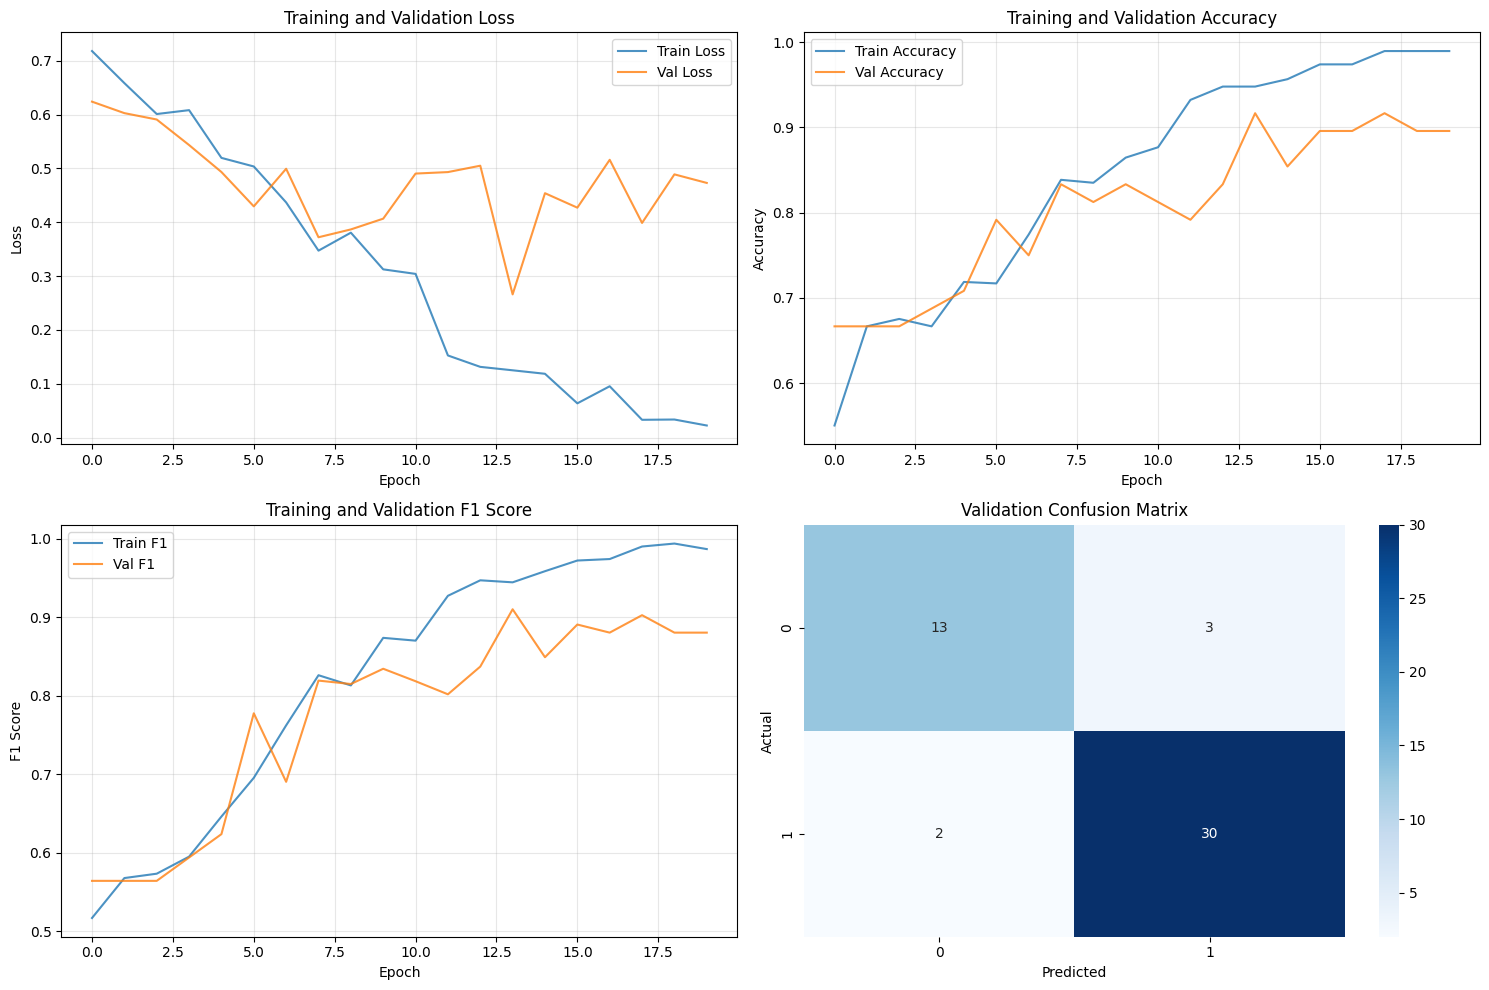


Detailed Classification Report:
--------------------------------------------------
                  precision    recall  f1-score   support

    Control (CN)     0.8667    0.8125    0.8387        16
Alzheimer's (AD)     0.9091    0.9375    0.9231        32

        accuracy                         0.8958        48
       macro avg     0.8879    0.8750    0.8809        48
    weighted avg     0.8949    0.8958    0.8950        48


Training completed successfully!
Model saved as 'best_alzheimer_model.pth'


In [ ]:
# ============================================================================
# STEP 6: MULTIMODAL MODEL ARCHITECTURE
# ============================================================================

class MultiModalTransformer(nn.Module):
    """Multimodal Transformer for Alzheimer's Detection combining BERT and ViT"""

    def __init__(self, num_classes=2, dropout_rate=0.3, fusion_dim=512):
        super(MultiModalTransformer, self).__init__()

        # Text branch - BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.text_dropout = nn.Dropout(dropout_rate)
        self.text_projection = nn.Linear(768, fusion_dim)

        # Audio branch - ViT for spectrograms
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.audio_dropout = nn.Dropout(dropout_rate)
        self.audio_projection = nn.Linear(768, fusion_dim)

        # Fusion layers
        self.fusion_attention = nn.MultiheadAttention(
            embed_dim=fusion_dim,
            num_heads=8,
            dropout=dropout_rate,
            batch_first=True
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim * 2, fusion_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fusion_dim, fusion_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fusion_dim // 2, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize classifier weights"""
        for module in [self.text_projection, self.audio_projection, self.classifier]:
            if isinstance(module, nn.Sequential):
                for layer in module:
                    if isinstance(layer, nn.Linear):
                        nn.init.xavier_uniform_(layer.weight)
                        nn.init.zeros_(layer.bias)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, input_ids, attention_mask, audio_features):
        # Text processing
        text_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        text_features = text_outputs.pooler_output  # [CLS] token representation
        text_features = self.text_dropout(text_features)
        text_features = self.text_projection(text_features)  # Shape: [batch, fusion_dim]

        # Audio processing
        audio_outputs = self.vit(pixel_values=audio_features)
        audio_features = audio_outputs.pooler_output  # Global representation
        audio_features = self.audio_dropout(audio_features)
        audio_features = self.audio_projection(audio_features)  # Shape: [batch, fusion_dim]

        # Cross-modal attention fusion
        # Prepare for attention: [batch, seq_len, embed_dim]
        text_for_attention = text_features.unsqueeze(1)  # [batch, 1, fusion_dim]
        audio_for_attention = audio_features.unsqueeze(1)  # [batch, 1, fusion_dim]

        # Cross-attention: text attending to audio
        text_attended, _ = self.fusion_attention(
            text_for_attention, audio_for_attention, audio_for_attention
        )
        text_attended = text_attended.squeeze(1)  # [batch, fusion_dim]

        # Cross-attention: audio attending to text
        audio_attended, _ = self.fusion_attention(
            audio_for_attention, text_for_attention, text_for_attention
        )
        audio_attended = audio_attended.squeeze(1)  # [batch, fusion_dim]

        # Concatenate attended features
        fused_features = torch.cat([text_attended, audio_attended], dim=1)  # [batch, fusion_dim*2]

        # Classification
        logits = self.classifier(fused_features)

        return logits, {
            'text_features': text_features,
            'audio_features': audio_features,
            'fused_features': fused_features,
            'text_attended': text_attended,
            'audio_attended': audio_attended
        }

# ============================================================================
# STEP 7: TRAINING UTILITIES
# ============================================================================

class EarlyStopping:
    """Early stopping utility"""

    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_score = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_score, model):
        if self.best_score is None:
            self.best_score = val_score
            self.save_checkpoint(model)
        elif val_score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
                return True
        else:
            self.best_score = val_score
            self.counter = 0
            self.save_checkpoint(model)
        return False

    def save_checkpoint(self, model):
        """Save model checkpoint for best performance"""
        self.best_weights = model.state_dict().copy()

class MetricsTracker:
    """Track training metrics"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.losses = []
        self.accuracies = []
        self.precisions = []
        self.recalls = []
        self.f1_scores = []

    def update(self, loss, y_true, y_pred):
        self.losses.append(loss)

        # Convert to numpy for sklearn metrics
        y_true_np = y_true.cpu().numpy() if torch.is_tensor(y_true) else y_true
        y_pred_np = y_pred.cpu().numpy() if torch.is_tensor(y_pred) else y_pred

        # Calculate metrics
        acc = accuracy_score(y_true_np, y_pred_np)
        prec = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
        rec = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
        f1 = f1_score(y_true_np, y_pred_np, average='weighted', zero_division=0)

        self.accuracies.append(acc)
        self.precisions.append(prec)
        self.recalls.append(rec)
        self.f1_scores.append(f1)

    def get_average_metrics(self):
        return {
            'loss': np.mean(self.losses) if self.losses else 0,
            'accuracy': np.mean(self.accuracies) if self.accuracies else 0,
            'precision': np.mean(self.precisions) if self.precisions else 0,
            'recall': np.mean(self.recalls) if self.recalls else 0,
            'f1_score': np.mean(self.f1_scores) if self.f1_scores else 0
        }

# ============================================================================
# STEP 8: TRAINING PIPELINE
# ============================================================================

class AlzheimerDetectionTrainer:
    """Complete training pipeline for Alzheimer's detection"""

    def __init__(self, model, train_loader, val_loader, device,
                 learning_rate=2e-5, weight_decay=0.01):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        # Loss function with class weighting
        self.criterion = nn.CrossEntropyLoss()

        # Optimizer with different learning rates for pretrained and new components
        self.optimizer = self._setup_optimizer(learning_rate, weight_decay)

        # Scheduler
        total_steps = len(train_loader) * 50  # Assuming max 50 epochs
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=total_steps, eta_min=1e-7
        )

        # Early stopping
        self.early_stopping = EarlyStopping(patience=10, min_delta=0.001)

        # Metrics tracking
        self.train_metrics = MetricsTracker()
        self.val_metrics = MetricsTracker()

        # History
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'train_f1': [], 'val_f1': []
        }

    def _setup_optimizer(self, learning_rate, weight_decay):
        """Setup optimizer with different learning rates for different components"""
        # Separate parameters for different learning rates
        bert_params = list(self.model.bert.parameters())
        vit_params = list(self.model.vit.parameters())
        other_params = []

        # Collect other parameters
        for name, param in self.model.named_parameters():
            if not name.startswith('bert.') and not name.startswith('vit.'):
                other_params.append(param)

        optimizer = optim.AdamW([
            {'params': bert_params, 'lr': learning_rate * 0.1},  # Lower LR for pretrained BERT
            {'params': vit_params, 'lr': learning_rate * 0.1},   # Lower LR for pretrained ViT
            {'params': other_params, 'lr': learning_rate}        # Standard LR for new layers
        ], weight_decay=weight_decay)

        return optimizer

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        self.train_metrics.reset()

        pbar = tqdm(self.train_loader, desc="Training")

        for batch in pbar:
            # Move to device
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            audio_features = batch['audio_features'].to(self.device)
            labels = batch['label'].to(self.device)

            # Forward pass
            self.optimizer.zero_grad()

            try:
                logits, features = self.model(input_ids, attention_mask, audio_features)
                loss = self.criterion(logits, labels)

                # Backward pass
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                self.optimizer.step()
                self.scheduler.step()

                # Predictions
                _, predicted = torch.max(logits.data, 1)

                # Update metrics
                self.train_metrics.update(loss.item(), labels, predicted)

                # Update progress bar
                current_metrics = self.train_metrics.get_average_metrics()
                pbar.set_postfix({
                    'Loss': f"{current_metrics['loss']:.4f}",
                    'Acc': f"{current_metrics['accuracy']:.4f}",
                    'F1': f"{current_metrics['f1_score']:.4f}"
                })

            except Exception as e:
                print(f"Error in training batch: {e}")
                continue

        return self.train_metrics.get_average_metrics()

    def validate_epoch(self):
        """Validate for one epoch"""
        self.model.eval()
        self.val_metrics.reset()

        all_predictions = []
        all_labels = []
        all_features = []

        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc="Validation")

            for batch in pbar:
                try:
                    # Move to device
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    audio_features = batch['audio_features'].to(self.device)
                    labels = batch['label'].to(self.device)

                    # Forward pass
                    logits, features = self.model(input_ids, attention_mask, audio_features)
                    loss = self.criterion(logits, labels)

                    # Predictions
                    _, predicted = torch.max(logits.data, 1)

                    # Store for analysis
                    all_predictions.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    all_features.append(features['fused_features'].cpu().numpy())

                    # Update metrics
                    self.val_metrics.update(loss.item(), labels, predicted)

                    # Update progress bar
                    current_metrics = self.val_metrics.get_average_metrics()
                    pbar.set_postfix({
                        'Loss': f"{current_metrics['loss']:.4f}",
                        'Acc': f"{current_metrics['accuracy']:.4f}",
                        'F1': f"{current_metrics['f1_score']:.4f}"
                    })

                except Exception as e:
                    print(f"Error in validation batch: {e}")
                    continue

        val_metrics = self.val_metrics.get_average_metrics()

        # Store predictions and features for analysis
        self.last_val_predictions = np.array(all_predictions)
        self.last_val_labels = np.array(all_labels)
        self.last_val_features = np.concatenate(all_features, axis=0) if all_features else None

        return val_metrics

    def train(self, num_epochs=30):
        """Complete training loop"""
        print(f"Starting training for {num_epochs} epochs...")
        print(f"Training samples: {len(self.train_loader.dataset)}")
        print(f"Validation samples: {len(self.val_loader.dataset)}")
        print("-" * 60)

        best_f1 = 0

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            # Train
            train_metrics = self.train_epoch()

            # Validate
            val_metrics = self.validate_epoch()

            # Update history
            self.history['train_loss'].append(train_metrics['loss'])
            self.history['val_loss'].append(val_metrics['loss'])
            self.history['train_acc'].append(train_metrics['accuracy'])
            self.history['val_acc'].append(val_metrics['accuracy'])
            self.history['train_f1'].append(train_metrics['f1_score'])
            self.history['val_f1'].append(val_metrics['f1_score'])

            # Print epoch results
            print(f"Train - Loss: {train_metrics['loss']:.4f}, "
                  f"Acc: {train_metrics['accuracy']:.4f}, "
                  f"F1: {train_metrics['f1_score']:.4f}")
            print(f"Val   - Loss: {val_metrics['loss']:.4f}, "
                  f"Acc: {val_metrics['accuracy']:.4f}, "
                  f"F1: {val_metrics['f1_score']:.4f}")

            # Save best model
            if val_metrics['f1_score'] > best_f1:
                best_f1 = val_metrics['f1_score']
                torch.save(self.model.state_dict(), 'best_alzheimer_model.pth')
                print(f"New best F1 score: {best_f1:.4f} - Model saved!")

            # Early stopping
            if self.early_stopping(val_metrics['f1_score'], self.model):
                print(f"\nEarly stopping triggered after {epoch+1} epochs")
                break

        print(f"\nTraining completed! Best F1 score: {best_f1:.4f}")
        return self.history

    def plot_training_history(self):
        """Plot training history"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Loss
        axes[0, 0].plot(self.history['train_loss'], label='Train Loss', alpha=0.8)
        axes[0, 0].plot(self.history['val_loss'], label='Val Loss', alpha=0.8)
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Accuracy
        axes[0, 1].plot(self.history['train_acc'], label='Train Accuracy', alpha=0.8)
        axes[0, 1].plot(self.history['val_acc'], label='Val Accuracy', alpha=0.8)
        axes[0, 1].set_title('Training and Validation Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # F1 Score
        axes[1, 0].plot(self.history['train_f1'], label='Train F1', alpha=0.8)
        axes[1, 0].plot(self.history['val_f1'], label='Val F1', alpha=0.8)
        axes[1, 0].set_title('Training and Validation F1 Score')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('F1 Score')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Confusion Matrix
        if hasattr(self, 'last_val_predictions') and hasattr(self, 'last_val_labels'):
            cm = confusion_matrix(self.last_val_labels, self.last_val_predictions)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
            axes[1, 1].set_title('Validation Confusion Matrix')
            axes[1, 1].set_xlabel('Predicted')
            axes[1, 1].set_ylabel('Actual')

        plt.tight_layout()
        plt.show()

    def generate_classification_report(self):
        """Generate detailed classification report"""
        if hasattr(self, 'last_val_predictions') and hasattr(self, 'last_val_labels'):
            print("\nDetailed Classification Report:")
            print("-" * 50)
            print(classification_report(
                self.last_val_labels,
                self.last_val_predictions,
                target_names=['Control (CN)', 'Alzheimer\'s (AD)'],
                digits=4
            ))
        else:
            print("No validation predictions available for report generation.")

# ============================================================================
# STEP 9: MAIN TRAINING EXECUTION
# ============================================================================

def train_alzheimer_model(train_loader, val_loader, device, num_epochs=25):
    """Main function to train the Alzheimer's detection model"""

    print("="*60)
    print("ALZHEIMER'S DETECTION MODEL TRAINING")
    print("="*60)

    # Initialize model
    print("Initializing multimodal model...")
    model = MultiModalTransformer(
        num_classes=2,
        dropout_rate=0.3,
        fusion_dim=512
    )

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Initialize trainer
    trainer = AlzheimerDetectionTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        learning_rate=2e-5,
        weight_decay=0.01
    )

    # Train model
    print(f"\nStarting training on {device}...")
    history = trainer.train(num_epochs=num_epochs)

    # Plot results
    trainer.plot_training_history()

    # Generate report
    trainer.generate_classification_report()

    return model, trainer, history

# Execute training if train_loader and val_loader are available
if 'train_loader' in globals() and 'val_loader' in globals() and train_loader is not None:
    print("Starting model training...")

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Train the model
    trained_model, trainer, training_history = train_alzheimer_model(
        train_loader, val_loader, device, num_epochs=20
    )

    print("\nTraining completed successfully!")
    print("Model saved as 'best_alzheimer_model.pth'")

else:
    print("train_loader and val_loader not found. Please run the data processing steps first.")
    print("You can run the training with:")
    print("trained_model, trainer, history = train_alzheimer_model(train_loader, val_loader, device)")